In [1]:
# Put reload
%reload_ext autoreload
%autoreload 2

# Imports

In [2]:
import sys

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
from sklearn.metrics import roc_auc_score
from torchvision import datasets
from tqdm import tqdm

sys.path.append("..")

from ratefunctiontorch import eval_cumulant, rate_function

In [3]:
BATCH_SIZE = 50


# Load Resnet And Datasets

In [4]:
model = torch.hub.load(
    "chenyaofo/pytorch-cifar-models", "cifar10_resnet20", pretrained=True
)

Using cache found in C:\Users\Ludvins/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master


In [5]:
# Load CIFAR10 data
transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)
trainset = datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform
)
train_loader = torch.utils.data.DataLoader(
    trainset,
    batch_size=BATCH_SIZE,
    shuffle=True,
)
testset = datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform
)
test_loader = torch.utils.data.DataLoader(
    testset,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

testset_svhn = datasets.SVHN(
    root="./data", split="test", download=True, transform=transform
)
test_loader2 = torch.utils.data.DataLoader(
    testset_svhn,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

Files already downloaded and verified
Files already downloaded and verified
Using downloaded and verified file: ./data\test_32x32.mat


# Cummulant

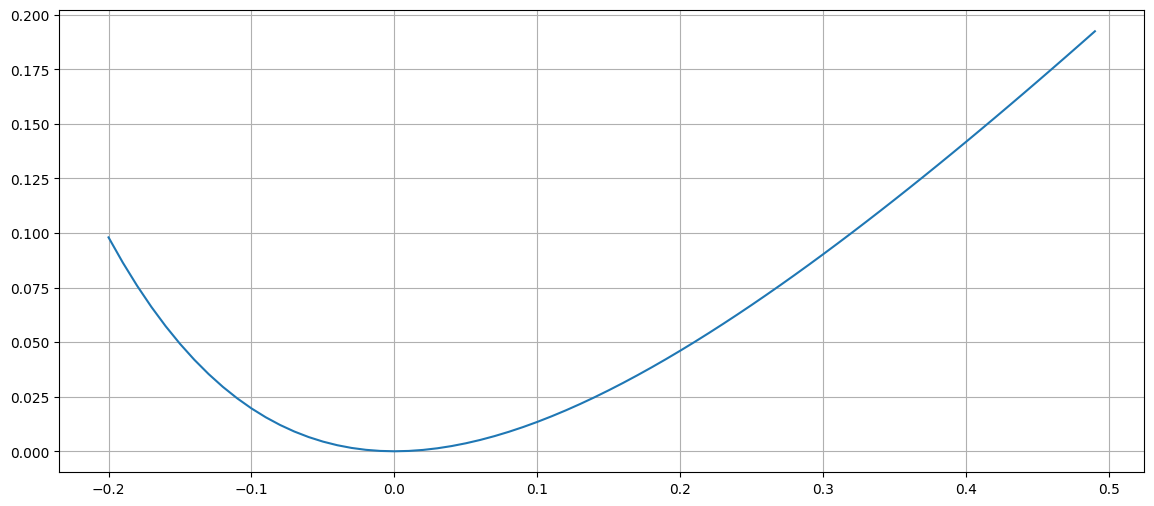

In [6]:
lambdas = np.arange(-0.2, 0.5, 0.01)
cummulant = eval_cumulant(model, lambdas, test_loader).detach().cpu().numpy()

plt.rcParams["figure.figsize"] = (14, 6)
plt.plot(lambdas, cummulant)
plt.grid()
plt.show()

# Rate Function

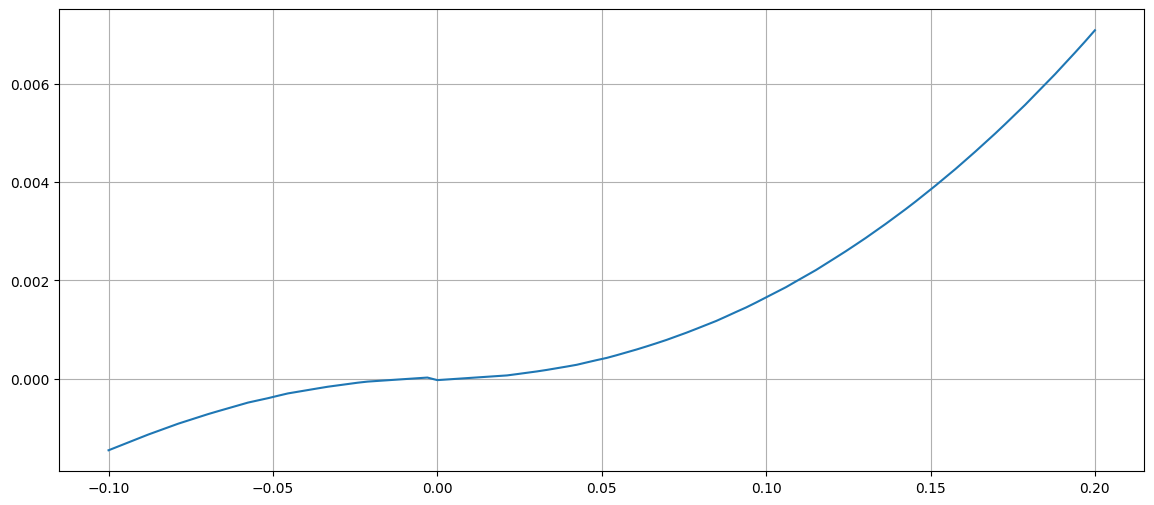

In [7]:
s_values = np.linspace(-0.1, 0.2, 100)


I = rate_function(model, s_values, test_loader)

plt.rcParams["figure.figsize"] = (14, 6)
plt.plot(s_values, I)
plt.grid()
plt.show()

# OOD

## Precompute loss for 1000 elements of each dataset

In [19]:
test_loader = torch.utils.data.DataLoader(
    testset,
    batch_size=1,
    shuffle=True,
)

test_loader2 = torch.utils.data.DataLoader(
    testset_svhn,
    batch_size=1,
    shuffle=True,
)

In [20]:
# Compute the loss on batches of the test set
losses_cifar = []
losses_svhn = []
n_batches = 1000
test_iter = iter(test_loader)
test_iter_svhn = iter(test_loader2)
for i in tqdm(range(n_batches)):
    try:
        inputs, labels = next(test_iter)
    except StopIteration:
        test_iter = iter(test_loader)

    outputs = model(inputs)
    loss = torch.nn.functional.cross_entropy(outputs, labels)
    losses_cifar.append(loss.item())

    try:
        inputs, labels = next(test_iter_svhn)
    except StopIteration:
        test_iter_svhn = iter(test_loader2)

    outputs = model(inputs)
    loss = torch.nn.functional.cross_entropy(outputs, labels)
    losses_svhn.append(loss.item())


100%|██████████| 1000/1000 [00:05<00:00, 182.07it/s]


## Compute and plot generalization errors. SVHN uses Cifar10 population loss

In [21]:
gen_errors_cifar = np.array(losses_cifar) - np.mean(losses_cifar)
gen_errors_svhn = np.array(losses_svhn) - np.mean(losses_cifar)

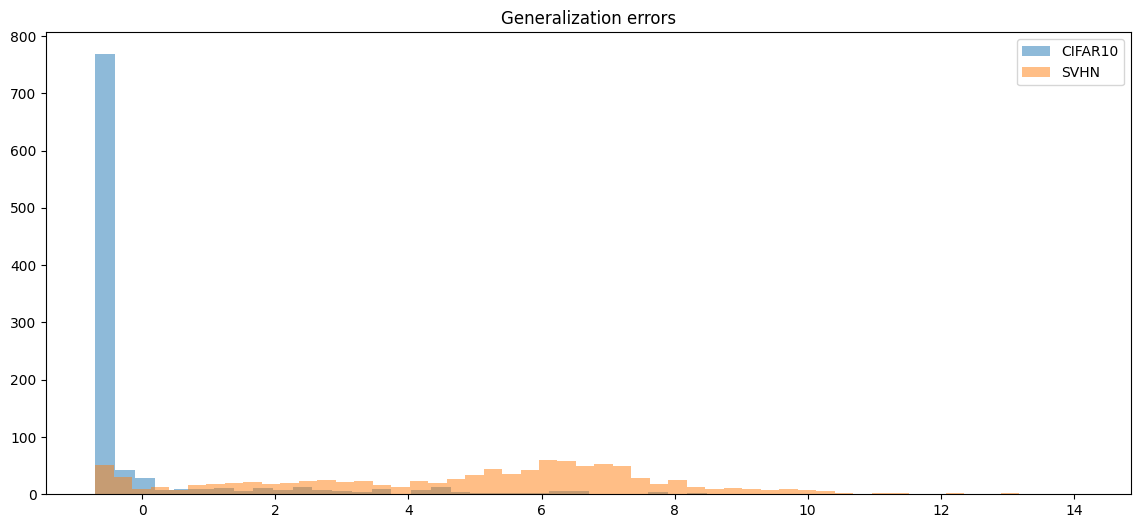

In [22]:
plt.hist(gen_errors_cifar, bins=50, alpha=0.5, label="CIFAR10")
plt.hist(gen_errors_svhn, bins=50, alpha=0.5, label="SVHN")
plt.legend()
plt.title("Generalization errors")
plt.show()

## Compute entropies and the AUC

In [38]:
# Compute the loss on batches of the test set
H_cifar = []
H_svhn = []
n_batches = 1000
test_iter = iter(test_loader)
test_iter_svhn = iter(test_loader2)
for i in tqdm(range(n_batches)):
    try:
        inputs, labels = next(test_iter)
    except StopIteration:
        test_iter = iter(test_loader)

    outputs = model(inputs).softmax(dim=1)

    # Compute entropy of predictions
    H = -torch.sum(outputs * torch.log(outputs), dim=1).detach().cpu().numpy()
    H_cifar.append(H)

    try:
        inputs, labels = next(test_iter_svhn)
    except StopIteration:
        test_iter_svhn = iter(test_loader2)

    outputs = model(inputs).softmax(dim=1)
    H = -torch.sum(outputs * torch.log(outputs), dim=1).detach().cpu().numpy()
    H_svhn.append(H)

100%|██████████| 1000/1000 [00:05<00:00, 177.27it/s]


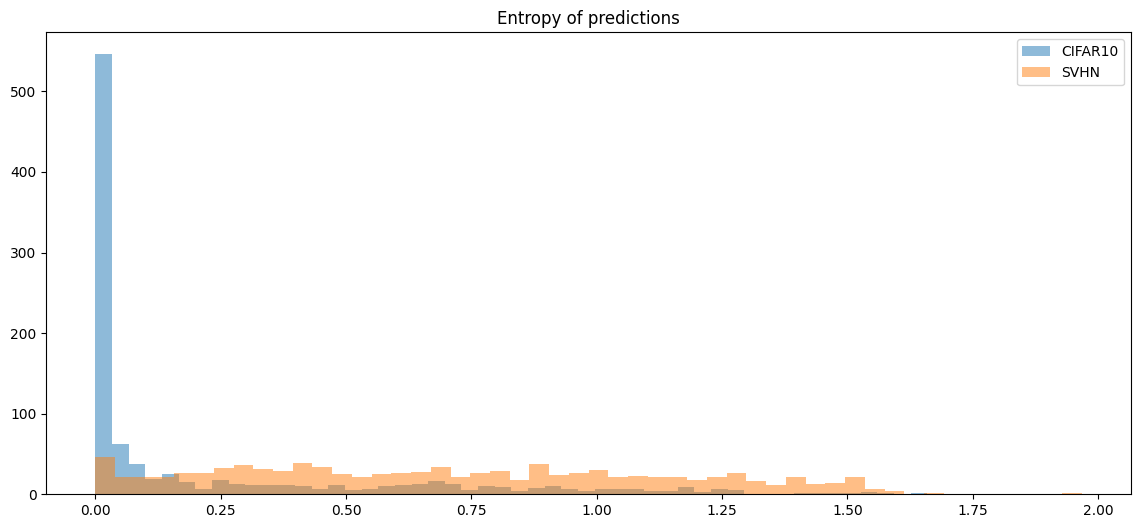

In [40]:
plt.hist(np.concatenate(H_cifar), bins=50, alpha=0.5, label="CIFAR10")
plt.hist(np.concatenate(H_svhn), bins=50, alpha=0.5, label="SVHN")
plt.legend()
plt.title("Entropy of predictions")
plt.show()

In [39]:
# Compute ouc on gen_errors_cifar and gen_errors_svhn
auc = roc_auc_score(
    [0] * len(H_cifar) + [1] * len(H_svhn),
    np.concatenate([H_cifar, H_svhn]),
)

print(f"AUC: {auc}")

AUC: 0.8372539999999999


## Compute Alphas and the AUC

In [23]:
alphas_cifar = rate_function(model, gen_errors_cifar, test_loader, verbose=True)
alphas_svhn = rate_function(model, gen_errors_svhn, test_loader, verbose=True)

100%|██████████| 1000/1000 [00:17<00:00, 58.60it/s]


In [41]:
# Compute ouc on gen_errors_cifar and gen_errors_svhn
auc = roc_auc_score(
    [0] * len(alphas_cifar) + [1] * len(alphas_svhn),
    np.concatenate([alphas_cifar, alphas_svhn]),
)

print(f"AUC: {auc}")

AUC: 0.937449


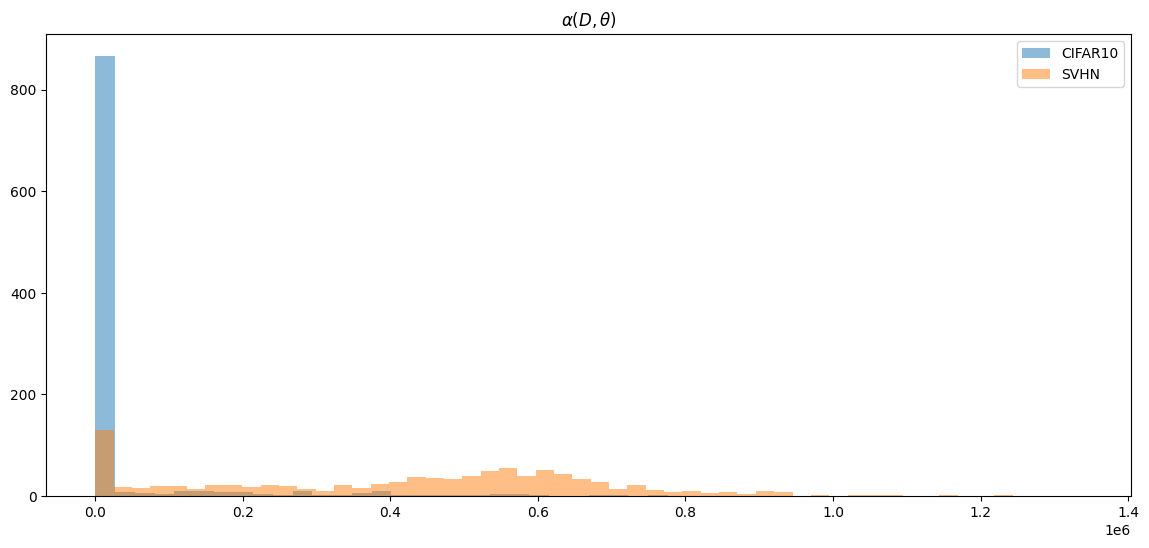

In [24]:
plt.hist(alphas_cifar, bins=50, alpha=0.5, label="CIFAR10")
plt.hist(alphas_svhn, bins=50, alpha=0.5, label="SVHN")
plt.title(r"$\alpha(D, \theta)$")
plt.legend()
plt.show()

## Compute probabilities using exponential CDF

In [29]:
# Take iteratively batches from cifar10 and svhn
n_batches = 10
test_iter = iter(test_loader)
test_iter_svhn = iter(test_loader2)

for i in range(n_batches):
    try:
        inputs, labels = next(test_iter)
    except StopIteration:
        test_iter = iter(test_loader)

    outputs = model(inputs)
    loss = torch.nn.functional.cross_entropy(outputs, labels)

    alpha = rate_function(model, [loss.item()], test_loader)
    print(
        "\nCifar10 sample with loss {} and alpha {}.".format(loss.item(), alpha.item())
    )
    print(
        "Probability of being out of distribution: ", 1 - np.exp(-np.abs(alpha.item()))
    )

    try:
        inputs, labels = next(test_iter_svhn)
    except StopIteration:
        test_iter_svhn = iter(test_loader2)

    outputs = model(inputs)
    loss = torch.nn.functional.cross_entropy(outputs, labels)

    alpha = rate_function(model, [loss.item()], test_loader)
    print("\nSVHN sample with loss {} and alpha {}.".format(loss.item(), alpha.item()))
    print(
        "Probability of being out of distribution: ", 1 - np.exp(-np.abs(alpha.item()))
    )


Threshhold: 6.907755278982137

Cifar10 sample with loss 0.0002874914789572358 and alpha -3.148231917293742e-05.
Probability of being out of distribution:  3.148182360990237e-05

SVHN sample with loss 6.878735542297363 and alpha 613250.6875.
Probability of being out of distribution:  1.0

Cifar10 sample with loss 1.1920858014491387e-05 and alpha -3.272841786383651e-05.
Probability of being out of distribution:  3.272788229502499e-05

SVHN sample with loss 1.5466725826263428 and alpha 80044.3828125.
Probability of being out of distribution:  1.0

Cifar10 sample with loss 0.0004267973708920181 and alpha -3.085239222855307e-05.
Probability of being out of distribution:  3.085191629836892e-05

SVHN sample with loss 8.611250877380371 and alpha 786502.1875.
Probability of being out of distribution:  1.0

Cifar10 sample with loss 8.356221951544285e-05 and alpha -3.240446312702261e-05.
Probability of being out of distribution:  3.240393810810538e-05

SVHN sample with loss 0.3067876994609833 and